In [2]:
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D,
                                     GlobalAveragePooling2D, BatchNormalization,
                                     Activation, Add, Concatenate, Dense, Dropout,
                                     Multiply, Reshape)
import os, kagglehub

# Disable XLA JIT (to avoid huge pinned‐host allocs)
tf.config.optimizer.set_jit(False)

# GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(" GPU memory growth enabled")
else:
    print(" No GPU detected")

mixed_precision.set_global_policy('mixed_float16')
print(" Mixed precision policy:", mixed_precision.global_policy())


2025-08-29 16:46:14.370257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756485974.577805      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756485974.639205      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 GPU memory growth enabled
 Mixed precision policy: <DTypePolicy "mixed_float16">


In [8]:
import os
import kagglehub

# Download the PlantVillage dataset by emmarex
path = kagglehub.dataset_download("emmarex/plantdisease")
print("Raw dataset path:", path)


main_folder = "PlantVillage"  # This is the main folder name
main_path = os.path.join(path, main_folder)
print("Main folder:", main_folder)
print("Contents of main folder:", os.listdir(main_path)[:5])

image_root = main_path
print("Image root folder:", image_root)

# List the disease classes
classes = os.listdir(image_root)
print("Classes found:", classes[:10])
print("Total number of classes:", len(classes))


Raw dataset path: /kaggle/input/plantdisease
Main folder: PlantVillage
Contents of main folder: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot']
Image root folder: /kaggle/input/plantdisease/PlantVillage
Classes found: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot']
Total number of classes: 15


In [9]:
import tensorflow as tf
import os

batch_size = 8
img_size = (160, 160)

# Load the train/validation split
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    image_root,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

dataset_val = tf.keras.preprocessing.image_dataset_from_directory(
    image_root,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Shuffle validation dataset before splitting into validation & test
dataset_val = dataset_val.shuffle(buffer_size=1000, seed=42)

# Calculate test size (25% of the initial validation set)
test_size = tf.data.experimental.cardinality(dataset_val).numpy() // 4

# Create test and updated validation datasets
test_data = dataset_val.take(test_size)
dataset_val = dataset_val.skip(test_size)

# Print dataset info
print(f"Number of validation batches: {tf.data.experimental.cardinality(dataset_val).numpy()}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_data).numpy()}")
print("Train element spec:", dataset_train.element_spec)
print("Validation element spec:", dataset_val.element_spec)
print("Test element spec:", test_data.element_spec)


Found 20638 files belonging to 15 classes.
Using 16511 files for training.


I0000 00:00:1756486008.663836      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Number of validation batches: 387
Number of test batches: 129
Train element spec: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))
Validation element spec: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))
Test element spec: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))


In [11]:
num_classes = dataset_train.element_spec[1].shape[-1]
print("Detected num_classes =", num_classes)

Detected num_classes = 15


In [12]:
#Preprocessing
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = (
    dataset_train
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(500)
    .prefetch(1)
)

val_ds = (
    dataset_val
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .prefetch(1)
)

In [14]:
import tensorflow as tf
import math
from tensorflow.keras import layers, regularizers, backend as K, Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, AveragePooling2D,
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,Reshape, Dot, Add, Lambda
)

In [15]:
def rsa_attention(x, reg_l2=1e-4, reg_l1=1e-4, name=None):
    C = x.shape[-1]
    H = x.shape[1]
    W = x.shape[2]
    N = H * W

    f = Conv2D(C,1,padding='same',use_bias=True,
               kernel_regularizer=regularizers.l2(reg_l2),
               bias_regularizer   =regularizers.l1(reg_l1),
               name=(name+"_f" if name else None))(x)
    g = Conv2D(C,1,padding='same',use_bias=True,
               kernel_regularizer=regularizers.l2(reg_l2),
               bias_regularizer   =regularizers.l1(reg_l1),
               name=(name+"_g" if name else None))(x)
    h = Conv2D(C,1,padding='same',use_bias=True,
               kernel_regularizer=regularizers.l2(reg_l2),
               bias_regularizer   =regularizers.l1(reg_l1),
               name=(name+"_h" if name else None))(x)

    f_flat = Reshape((N, C), name=(name+"_reshape_f" if name else None))(f)
    g_flat = Reshape((N, C), name=(name+"_reshape_g" if name else None))(g)
    h_flat = Reshape((N, C), name=(name+"_reshape_h" if name else None))(h)

    scores = Dot(axes=(2,2), name=(name+"_score" if name else None))([f_flat, g_flat])

    inv_sqrt_C = 1.0 / math.sqrt(C)
    scores = Lambda(lambda t: t * inv_sqrt_C,
                    name=(name+"_scale" if name else "rsa_scale"))(scores)

    alpha = Activation('softmax', name=(name+"_softmax" if name else "rsa_softmax"))(scores)
    o_flat = Dot(axes=(2,1), name=(name+"_apply" if name else "rsa_apply"))([alpha, h_flat])
    o = Reshape((H, W, C), name=(name+"_out" if name else "rsa_out"))(o_flat)
    return o

In [17]:
#Model building blocks

def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters,3,strides=stride,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x); x=Activation('relu')(x)
    x = Conv2D(filters,3,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    if stride!=1 or shortcut.shape[-1]!=filters:
        shortcut = Conv2D(filters,1,strides=stride,use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x,shortcut]); return Activation('relu')(x)

def residual_block_group(x, f, n, stride=1):
    x = residual_block(x,f,stride)
    for _ in range(1,n):
        x = residual_block(x,f,1)
    return x

def dense_block(x, layers_n, g_rate):
    feats = [x]
    for _ in range(layers_n):
        y = Concatenate()(feats)
        y = BatchNormalization()(y); y=Activation('relu')(y)
        y = Conv2D(4*g_rate,1,padding='same',use_bias=False)(y)
        y = BatchNormalization()(y); y=Activation('relu')(y)
        y = Conv2D(g_rate,3,padding='same',use_bias=False)(y)
        feats.append(y)
    return Concatenate()(feats)

def transition_layer(x):
    x = BatchNormalization()(x)
    x = Conv2D(x.shape[-1]//2,1,padding='same',use_bias=False)(x)
    return AveragePooling2D(2,2)(x)


In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks, optimizers, losses
import os
from google.colab import drive



def build_rsa_derefnet(input_shape=(160,160,3), num_classes=15, growth_rate=12):
    i = Input(shape=input_shape)

    # Initial conv
    x0 = Conv2D(32,3,padding='same',use_bias=False)(i)
    x0 = BatchNormalization()(x0); x0 = Activation('relu')(x0)

    # Residual stream with RSA
    r1 = residual_block_group(x0,  64, 1, stride=1)
    p1 = AveragePooling2D(pool_size=4)(r1)
    a1 = rsa_attention(p1, name="res1")
    r2 = residual_block_group(a1, 128, 1, stride=2)
    p2 = AveragePooling2D(pool_size=2)(r2)
    a2 = rsa_attention(p2, name="res2")
    r3 = residual_block_group(a2, 256, 1, stride=2)
    g_r = GlobalAveragePooling2D()(r3)

    # Dense stream with RSA
    d1 = Conv2D(32,3,padding='same',use_bias=False)(i)
    d1 = BatchNormalization()(d1); d1 = Activation('relu')(d1)
    d1 = MaxPooling2D(2)(d1)
    db1 = dense_block(d1, 3, growth_rate)
    t1 = transition_layer(db1)
    a3 = rsa_attention(t1, name="dens1")
    db2 = dense_block(a3, 3, growth_rate)
    t2 = transition_layer(db2)
    a4 = rsa_attention(t2, name="dens2")
    db3 = dense_block(a4, 5, growth_rate)
    g_d = GlobalAveragePooling2D()(db3)

    # Fuse & classify
    f = Concatenate()([g_r, g_d])
    f = Dropout(0.5)(f)
    out = Dense(num_classes, activation='softmax', dtype='float32')(f)

    return Model(i, out)

# Learning rate schedule
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Build and compile the model
model = build_rsa_derefnet(
    input_shape=(160,160,3),
    num_classes=num_classes,
    growth_rate=12
)
from tensorflow.keras import optimizers, losses

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
total_steps = steps_per_epoch * 30

cosine = optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-4, decay_steps=total_steps
)

opt = optimizers.AdamW(learning_rate=cosine, weight_decay=1e-4, clipnorm=1.0)

model.compile(
    optimizer=opt,
    loss=losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


print(model.summary())




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 160, 160, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 160, 160, 32)   │            864 │ cast_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 160, 160, 32)   │            128 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 160, 160, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 80, 80, 32)     │              0 │ activation_7[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 80, 80, 32)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 80, 80, 32)     │            128 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 80, 80, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 80, 80, 48)     │          1,536 │ activation_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 80, 80, 48)     │            192 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 80, 80, 48)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 80, 80, 12)     │          5,184 │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 80, 80, 44)     │              0 │ max_pooling2d[0][0],   │
│ (Concatenate)             │                        │                │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 80, 80, 44)     │            176 │ concatenate_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 80, 80, 44)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 1,380,060 (5.26 MB)

 Trainable params: 1,374,782 (5.24 MB)

 Non-trainable params: 5,278 (20.62 KB)

None


In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)


Epoch 1/30


I0000 00:00:1756486097.280731     104 service.cc:148] XLA service 0x78eef4002240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756486097.281614     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756486103.661972     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2064 ━━━━━━━━━━━━━━━━━━━━ 51:03:54 89s/step - accuracy: 0.0000e+00 - loss: 4.0436

I0000 00:00:1756486138.548781     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2064/2064 ━━━━━━━━━━━━━━━━━━━━ 235s 71ms/step - accuracy: 0.4849 - loss: 2.0555 - val_accuracy: 0.7053 - val_loss: 1.4062
Epoch 2/30
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 100s 48ms/step - accuracy: 0.7640 - loss: 1.2720 - val_accuracy: 0.8397 - val_loss: 1.0971
Epoch 3/30
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 100s 48ms/step - accuracy: 0.8266 - loss: 1.1277 - val_accuracy: 0.6672 - val_loss: 1.4871
Epoch 4/30
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 100s 48ms/step - accuracy: 0.8614 - loss: 1.0428 - val_accuracy: 0.8620 - val_loss: 1.0103
Epoch 5/30
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 100s 48ms/step - accuracy: 0.8919 - loss: 0.9784 - val_accuracy: 0.9276 - val_loss: 0.8842
Epoch 6/30
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 100s 48ms/step - accuracy: 0.9012 - loss: 0.9434 - val_accuracy: 0.9415 - val_loss: 0.8461
Epoch 7/30
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 100s 48ms/step - accuracy: 0.9198 - loss: 0.8969 - val_accuracy: 0.8346 - val_loss: 1.0456
Epoch 8/30
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 101s 48ms/step - accuracy: 0.9274 - lo

In [20]:
model.save("/content/PlantVilage_withGradCam.h5")

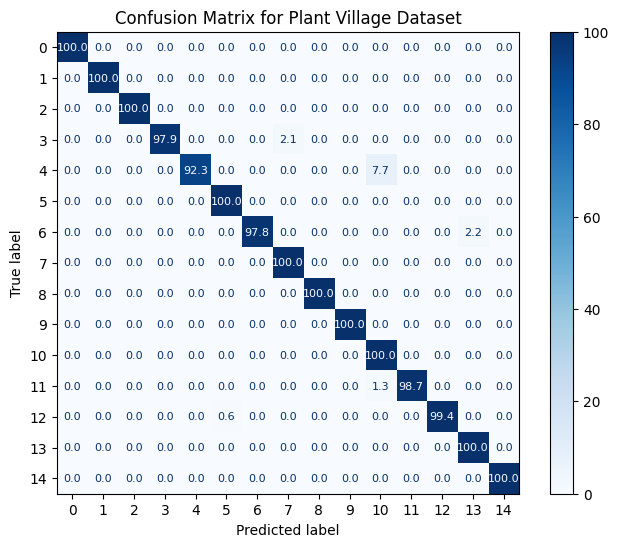

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = []
y_pred = []

# Preprocess test data
test_ds = (
    test_data
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .prefetch(1)
)

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)

    # Convert one-hot labels and predictions to class indices
    labels = np.argmax(labels.numpy(), axis=1)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels)
    y_pred.extend(preds)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to percentages (row-wise)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Display confusion matrix with smaller font
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', values_format=".1f", ax=ax)

# Reduce annotation font size
for text in ax.texts:
    text.set_fontsize(8)  # Set to 8; you can try 6–10 depending on clarity

plt.title("Confusion Matrix for Plant Village Dataset")
plt.show()



Heatmap shape: (20, 20)
Heatmap values (first 10x10): [[0.1609  0.3562  0.3218  0.4138  0.4023  0.4023  0.4138  0.4023  0.4023
  0.3909 ]
 [0.4368  0.506   0.4712  0.5747  0.54    0.54    0.54    0.54    0.552
  0.5747 ]
 [0.4253  0.4597  0.4482  0.4597  0.3909  0.4023  0.4597  0.4597  0.506
  0.506  ]
 [0.4368  0.4712  0.4712  0.4827  0.4368  0.4712  0.4941  0.4597  0.4253
  0.529  ]
 [0.4482  0.4712  0.4712  0.529   0.4368  0.4712  0.563   0.517   0.5747
  0.552  ]
 [0.4482  0.4597  0.4941  0.517   0.529   0.6553  0.4712  0.4597  0.3909
  0.4482 ]
 [0.4368  0.4712  0.4597  0.54    0.6553  0.368   0.4138  0.517   0.4368
  0.6323 ]
 [0.4597  0.4482  0.54    0.563   0.1954  0.3333  0.4597  0.517   0.4482
  0.8853 ]
 [0.4482  0.5747  0.506   0.3794  0.08044 0.2644  0.4482  0.724   0.4827
  0.724  ]
 [0.4597  0.54    0.552   0.517   0.1265  0.3447  0.2644  0.529   0.5747
  0.724  ]]


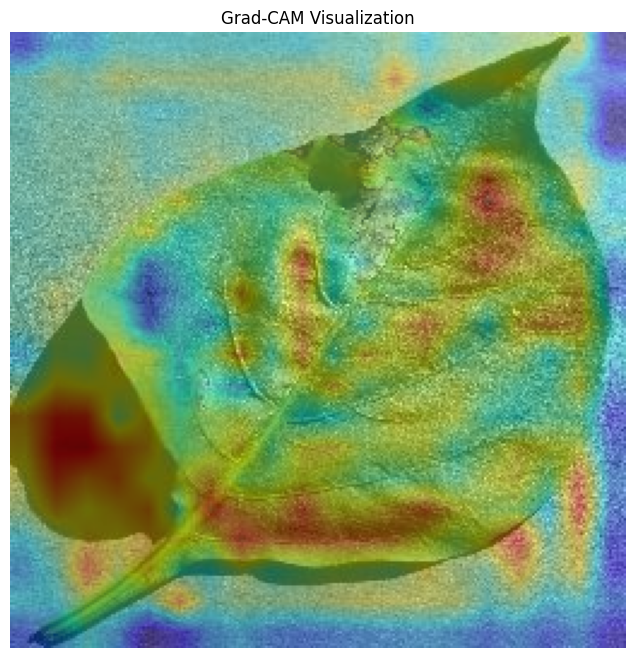

In [53]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os

# --------- CONFIGURE THIS ---------
last_conv_layer_name = "conv2d_34"  # Change to your model's last conv layer
# Update img_path to point to a file within the downloaded dataset
img_path = "/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG"  # Replace with your test image path
# Check if the path exists and get a sample image if not
if not os.path.exists(img_path):
    print(f"Image path not found: {img_path}")
    # Fallback to a known image path from the dataset if the specified one doesn't exist
    sample_class_dir = os.path.join(image_root, classes[0])
    if os.path.isdir(sample_class_dir):
        sample_image_name = os.listdir(sample_class_dir)[0]
        img_path = os.path.join(sample_class_dir, sample_image_name)
        print(f"Using sample image: {img_path}")
    else:
        raise FileNotFoundError("Could not find a valid image path.")


target_size = (160, 160)  # Change to your model's input size
# -----------------------------------

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

# Preprocess your image
img = tf.keras.preprocessing.image.load_img(img_path) # Load the image without resizing
original_img_size = img.size # Get the original size

img_resized = tf.keras.preprocessing.image.img_to_array(img.resize(target_size)) # Resize for model input
img_array = np.expand_dims(img_resized, axis=0) / 255.0  # adjust if your model uses different preprocessing


# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name)

print("Heatmap shape:", heatmap.shape)
print("Heatmap values (first 10x10):", heatmap[:10, :10])


# Resize heatmap to original image size using TensorFlow
heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], (original_img_size[1], original_img_size[0]))
heatmap_resized = tf.squeeze(heatmap_resized).numpy()

heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Superimpose heatmap on the original image
superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, heatmap_colored, 0.4, 0)

# Display result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()

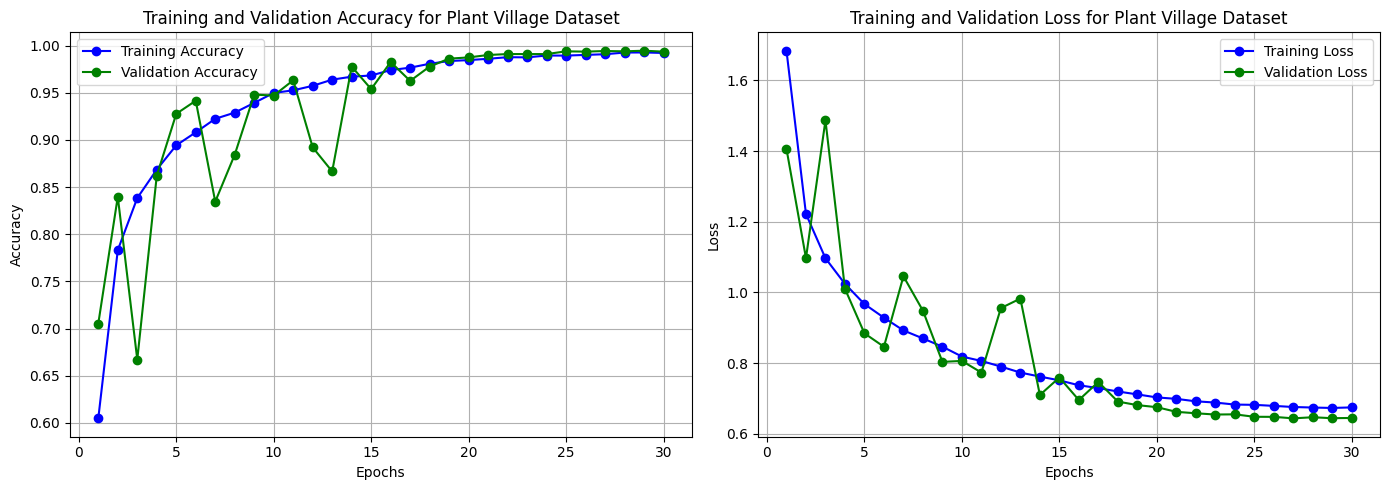

In [46]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy for Plant Village Dataset')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
    plt.title('Training and Validation Loss for Plant Village Dataset')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)
